Using and understanding SHAP Values (Bhargav Ashok)

This notebook goes over how to use SHAP Values and how to read SHAP plots in a Random foreset Dataset (ML) Model. Dataset and references will be cited below.

A definition of Shapley Values can be explained by DataCamp:

"SHAP (SHapley Additive exPlanations) values are a way to explain the output of any machine learning model. It uses a game theoretic approach that measures each player's contribution to the final outcome. In machine learning, each feature is assigned an importance value representing its contribution to the model's output.

SHAP values show how each feature affects each final prediction, the significance of each feature compared to others, and the model's reliance on the interaction between features".

We will use Shapley's feature plots as well as a dependency plot to show one way to interpret a Machine Learning Model.

Using a dataset about stress/anxiety levels in stuents, found on kaggle, The questions we are trying to answer are as follows:

1. How do certian variabes affect the stress level of students? 
2. Which feature is the most important?
3. Which feature has the least impact?

In [ ]:
#load libraries
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')


C:\Users\bharg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Load dataset

df_stress_Level = pd.read_csv('StressLevelDataset.csv')

head = df_stress_Level.head() #Head of DataFrame
print(head)


   anxiety_level  self_esteem  mental_health_history  depression  headache  \
0             14           20                      0          11         2   
1             15            8                      1          15         5   
2             12           18                      1          14         2   
3             16           12                      1          15         4   
4             16           28                      0           7         2   

   blood_pressure  sleep_quality  breathing_problem  noise_level  \
0               1              2                  4            2   
1               3              1                  4            3   
2               1              2                  2            2   
3               3              1                  3            4   
4               3              5                  1            3   

   living_conditions  ...  basic_needs  academic_performance  study_load  \
0                  3  ...            2        

We take a look at this dataset, involving stress and anxiety levels for students and see the many factors and ranges present within the dataset. We will then check the info of the dataset to see if the data is normalized and ready for model fitting.

In [4]:
df_stress_Level.info() #check if balacing dataset needs to be done


null_values = df_stress_Level.isnull().sum() #check for null values
print(null_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   anxiety_level                 1100 non-null   int64
 1   self_esteem                   1100 non-null   int64
 2   mental_health_history         1100 non-null   int64
 3   depression                    1100 non-null   int64
 4   headache                      1100 non-null   int64
 5   blood_pressure                1100 non-null   int64
 6   sleep_quality                 1100 non-null   int64
 7   breathing_problem             1100 non-null   int64
 8   noise_level                   1100 non-null   int64
 9   living_conditions             1100 non-null   int64
 10  safety                        1100 non-null   int64
 11  basic_needs                   1100 non-null   int64
 12  academic_performance          1100 non-null   int64
 13  study_load                    110

In this case, the data is uniform and ready to go (a rare occurence in the world of Machine Learning and Data Science)! So we can now proceed with our model.

In [ ]:
X = df_stress_Level[['self_esteem', 'mental_health_history',
                     'blood_pressure', 'sleep_quality', 'living_conditions',
                     'social_support','anxiety_level', 'safety']] #Features
y = df_stress_Level['stress_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

model = RandomForestRegressor(n_estimators=100, random_state=0) #We use the regression model here
model.fit(X_train, y_train) #model fitting 

y_pred = model.predict(X_test) #model prediction
print(y_pred)

[0.   1.   2.   0.   1.43 1.   1.   1.   2.   1.31 1.   2.   0.   0.9
 1.   1.   2.   0.87 0.   0.   0.   1.   2.   1.55 2.   0.   0.67 0.66
 1.3  0.   0.   2.   0.49 0.   2.   1.   1.   0.   1.   0.   1.   0.
 1.   1.   1.   0.   0.   1.   1.   2.   1.   0.   1.   2.   2.   1.23
 1.   0.61 0.   2.   0.   1.   0.   0.98 1.   0.   1.   0.   0.   1.25
 1.   1.   0.   2.   1.   1.   0.   1.   1.   1.   1.31 1.52 0.96 1.
 0.   0.   0.   2.   1.   1.   1.   0.91 1.   2.   2.   1.59 2.   0.
 0.86 2.   2.   2.   2.   1.   0.   1.25 2.   1.   1.45 1.   1.   1.14
 0.   0.43 2.   0.   1.   2.   2.   1.   1.15 1.   0.   0.   0.7  0.
 1.   2.   0.   1.   2.   1.   0.   0.   2.   2.   2.   2.   1.   1.
 1.06 0.   2.   0.   1.   0.96 2.   1.   0.   0.97 2.   2.   2.   0.
 2.   0.   0.   1.   0.   1.13 1.   1.   0.45 0.   0.   2.   2.   0.84
 0.   1.   0.   2.   1.   1.   2.   2.   1.   2.   2.   0.   0.   2.
 0.82 1.28 0.98 2.   1.   1.   1.   1.03 0.   2.   0.73 2.   0.96 0.
 1.46 1.01 2.   2.   2.

These are our predicted values! Interesting right? But how do we actually interpret this data? How do we find out if out model is accurate? Well we can try a couple of things.

In [6]:
r2 = r2_score(y_test, y_pred) #R2 score
print("R2 Score:", r2) #0.82, strong, correlation, good model fit


R2 Score: 0.8210324965612105


Here we see that our R squared value has a strong correlation, and can be indicative of model accuracy, which is great! This is one way of explaining/interpreting our model. However, I want to go deeper. I want to see how each feature value has affected our target variable of stress level. This is where a game theory approach with Shapley Values matters. 

According to a book titled "Interpreting Machine Learning Models with SHAP" by Christoph Molnar:

"The Shapley value, coined by Shapley (1953), is a method for assigning payouts to players depending on their contribution to the total payout. Players cooperate in a coalition and receive a certain profit from this cooperation.

Players? Game? Payout? What’s the connection to machine learning predictions and interpretability? The “game” is the prediction task for a single instance of the dataset. The “gain” is the actual prediction for this instance minus the average prediction for all instances. The “players” are the feature values of the instance that collaborate to receive the gain (= predict a certain value)".

In our case the "game" is the theoretical predicted stress level with all of the current features in the enitre dataset (we will call this v1). The "gain(s)" are the specific feature predictions used in out Random Forest Regression Model (we will call this v2) (You can use Multi-Linear Regression as well) subtracted from the actual theoretical prediction (v1 - v2). The specific features that affected this difference can be explained with otu shaply plots.


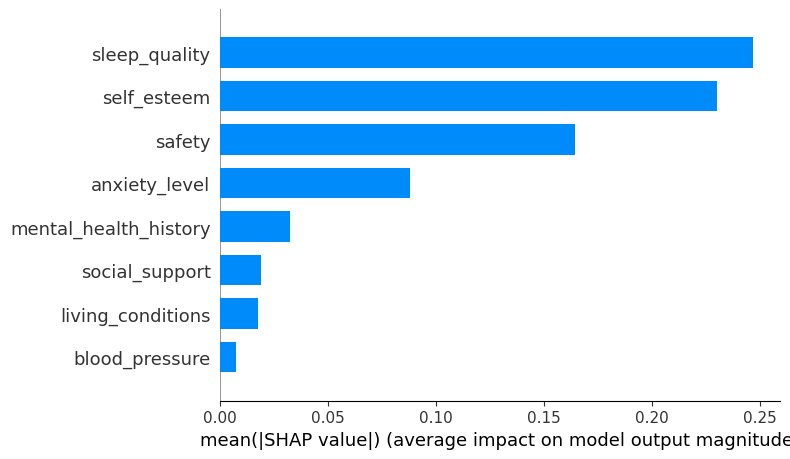

In [7]:
#SHAP plots and values
explainer = shap.TreeExplainer(model) #this explains our model output
shap_values = explainer.shap_values(X_train) #this grabs our trained X values

shap.summary_plot(shap_values, X_train, plot_type="bar") #Bar plot (importance of features)

Here, we see that once we load in our model into the SHAP library, we can do some data visualization with our festures. Here we can see that sleep quality is the most important feature in our model which affected the dataset. We also see that blood pressure was the least important feature that affected our dataset for this model.

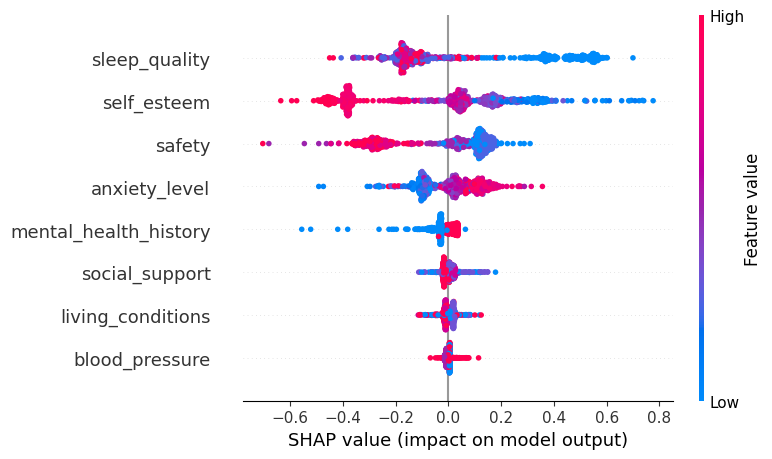

In [8]:
shap.summary_plot(shap_values, X_train) #regular plot (Variability of feature impact visualized)


We can go deeper by looking at all of our predicted Shapley Values to see how the average prediction in our dataset impacts each and every specific value (red being a high effectiveness and blue being the opposite). We can still see that Sleep Quality is the most effective feature, but it is interesting to see the blue dots in the plot, as the variability in the feature is more apparent here. This could be due to higher predicted Shapley values for this specific feature. All datapoints are normalized (as shown above).

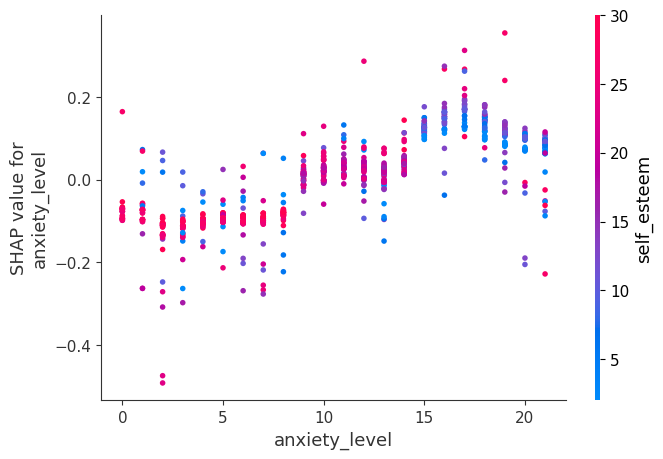

In [9]:
#Dependence plot: how one or two features affect the model output
shap.dependence_plot("anxiety_level", shap_values, X_train)

Here, we see a dependence plot of the top two features and how it affects our target variable. We can see vaugely see a linear correlation between all of these data points.

Summary:
The code above reflects a dataset containing various features that
 may contribute to stress levels in students.

 We can assume that sleep quality and self esteem have the highest effect on stress levels in students based on this specfic dataset.

 Future improvements: Denser dataset with more diverse output, improving the model to increase feature accuracy, trying/scoping out different models in the dataset, etc.
 
 The model is a Random Forest Regressor since most variables are numerical and continuous.

 The R2 score of 0.82 indicates a strong correlation between all of the features and the stress level.

 The SHAP plots indicate that sleep quality, self-esteem, and safety
 are the most important features in determining stress level.

 The SHAP summary plot shows more specifically how each feature impacts the 
 model's predictions based on each data point.

 SHAP values do a great job of explaining how each factor affects the target variable in a 
 dataset. It is a type of explainable/interpretable Machine Learning Framework/process that
 is widley used in the industry for production ML models, Explainable AI, and Data Science.

 This is an intro to some of the plots in SHAP for describing feature importance and impact.
 There are even more plots in the SHAP library that I have not discussed which can help with ML model
 debugging, insight and more. More information will be found in the reference section.

 Author: Bhargav Ashok, Virginia Tech '27, Computational Modeling and Data Analytics



REFERENCES:
- https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#Explaining-a-non-additive-boosted-tree-model

- Inspiration/learning: https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-shapley-values/notebook

- https://christophm.github.io/interpretable-ml-book/shapley.html#shapley

- https://mlu-explain.github.io/random-forest/

- https://www.datacamp.com/tutorial/random-forests-classifier-python

- https://pianalytix.com/random-forest-classifier-and-regressor/

- https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

- https://github.com/shap/shap

- Dataset: https://www.kaggle.com/datasets/rxnach/student-stress-factors-a-comprehensive-analysis/data